In [3]:
! pip install -r https://raw.githubusercontent.com/iniestaserranoalberto/NLP/main/requirements.txt

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-k04jkdcf
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-k04jkdcf
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Cloning https://github.com/amaiya/stellargraph (to revision no_tf_dep_082) to /tmp/pip-req-build-1cajyt2f
  Running command git clone -q https://github.com/amaiya/stellargraph /tmp/pip-req-build-1cajyt2f
  Running command git checkout -b no_tf_dep_082 --track origin/no_tf_dep_082
  Switched to a new branch 'no_tf_dep_082'
  Branch 'no_tf_dep_082' set up to track remote branch 'no_tf_dep_082' from 'origin'.
     |████████████████████████████████| 358kB 8.1MB/s 
     |████████████████████████████████| 204kB 14.9MB/s 
     |████████████████████████████████| 727kB 15.2MB/s 
     |█████████████

In [4]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk
import os

import regex
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import wordnet

nltk.download('stopwords')

from collections import Counter

from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import of 20news groups train dataset

Import of 20news train dataset from sklearn.datasets. 

In [5]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
training_df = pd.DataFrame()
training_df['Text'] = dataset.data
training_df['source'] = dataset.target
label=[]
for i in training_df['source']:
    label.append(dataset.target_names[i])
training_df['Class']=label

In [6]:
training_df.head()

,Text,source,Class
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


In [7]:
training_df.drop(['source'],axis=1,inplace=True)

There is a total of 20 categories in the train dataset.

In [8]:
training_df['Class'].value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: Class, dtype: int64

In the next step some of the categories are combined together as simplification purposes.

In [9]:
training_df['Class'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'},inplace=True)
                    
# replace to sport
training_df['Class'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'},inplace=True)
                    
# replace to religion
training_df['Class'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion','alt.atheism':'religion'},inplace=True)
                    
# replace to computer
training_df['Class'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'},inplace=True)  
# replace to sales
training_df['Class'].replace({'misc.forsale':'sales'},inplace=True)

# replace to automobile
training_df['Class'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'},inplace=True)

# replace to science
training_df['Class'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science','sci.med':'medicine'},inplace=True)

# replace to medicine
training_df['Class'].replace({'sci.med':'medicine'},inplace=True)

In [10]:
training_df['Class'].nunique()

8

In [11]:
training_df['Class'].value_counts()

computer      2936
science       1779
politics      1575
religion      1456
sport         1197
automobile    1192
medicine       594
sales          585
Name: Class, dtype: int64

In [12]:
training_df = training_df[training_df['Class'].isin(['religion', 'automobile', 'medicine','sport'] )]

In [13]:
training_df['words_count'] = training_df['Text'].apply(lambda x:len(str(x).split()))
training_df.head()

,Text,Class,words_count
0,I was wondering if anyone out there could enli...,automobile,91
6,There were a few people who responded to my re...,medicine,63
10,I have a line on a Ducati 900GTS 1978 model wi...,automobile,108
11,"\nYep, that's pretty much it. I'm not a Jew bu...",religion,472
15,\nDon't be so sure. Look what happened to Jap...,religion,94


In [14]:
no_text = training_df[training_df['words_count']==0]
print(len(no_text))

136


In [15]:
training_df.drop(no_text.index,inplace=True)
print(len(no_text))

136


In [16]:
no_text = training_df[training_df['words_count']==0]
print(len(no_text))

0


In [17]:
training_df

,Text,Class,words_count
0,I was wondering if anyone out there could enli...,automobile,91
6,There were a few people who responded to my re...,medicine,63
10,I have a line on a Ducati 900GTS 1978 model wi...,automobile,108
11,"\nYep, that's pretty much it. I'm not a Jew bu...",religion,472
15,\nDon't be so sure. Look what happened to Jap...,religion,94
...,...,...,...
11296,\n\n\n\n\n Anaheim.,sport,1
11298,After reading some of the reports of possible ...,sport,186
11300,\nI am asking you to believe in things not vis...,religion,447
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,medicine,300


# Import of 20news groups test dataset

Import of 20news test dataset from sklearn.datasets. 

In [18]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
test_df = pd.DataFrame()
test_df['Text'] = dataset.data
test_df['source'] = dataset.target
label=[]
for i in test_df['source']:
    label.append(dataset.target_names[i])
test_df['Class']=label

In [19]:
test_df.head()

,Text,source,Class
0,I am a little confused on all of the models of...,7,rec.autos
1,I'm not familiar at all with the format of the...,5,comp.windows.x
2,"\nIn a word, yes.\n",0,alt.atheism
3,\nThey were attacking the Iraqis to drive them...,17,talk.politics.mideast
4,\nI've just spent two solid months arguing tha...,19,talk.religion.misc


In [20]:
test_df.drop(['source'],axis=1,inplace=True)

There is a total of 20 categories in the train dataset.

In [21]:
test_df['Class'].value_counts()

rec.sport.hockey            399
rec.motorcycles             398
soc.religion.christian      398
rec.sport.baseball          397
sci.crypt                   396
sci.med                     396
rec.autos                   396
comp.windows.x              395
sci.space                   394
comp.os.ms-windows.misc     394
sci.electronics             393
comp.sys.ibm.pc.hardware    392
misc.forsale                390
comp.graphics               389
comp.sys.mac.hardware       385
talk.politics.mideast       376
talk.politics.guns          364
alt.atheism                 319
talk.politics.misc          310
talk.religion.misc          251
Name: Class, dtype: int64

In the next step some of the categories are combined together as simplification purposes.

In [22]:
test_df['Class'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'},inplace=True)
                    
# replace to sport
test_df['Class'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'},inplace=True)
                    
# replace to religion
test_df['Class'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion','alt.atheism':'religion'},inplace=True)
                    
# replace to computer
test_df['Class'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'},inplace=True)  
# replace to sales
test_df['Class'].replace({'misc.forsale':'sales'},inplace=True)

# replace to automobile
test_df['Class'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'},inplace=True)

# replace to science
test_df['Class'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'},inplace=True)

# replace to medicine
test_df['Class'].replace({'sci.med':'medicine'},inplace=True)

In [23]:
test_df['Class'].nunique()

8

In [24]:
test_df['Class'].value_counts()

computer      1955
science       1183
politics      1050
religion       968
sport          796
automobile     794
medicine       396
sales          390
Name: Class, dtype: int64

In [25]:
test_df = test_df[test_df['Class'].isin(['religion', 'automobile', 'medicine','sport'] )]

In [26]:
test_df['words_count'] =test_df['Text'].apply(lambda x:len(str(x).split()))
test_df.head()

,Text,Class,words_count
0,I am a little confused on all of the models of...,automobile,92
2,"\nIn a word, yes.\n",religion,4
4,\nI've just spent two solid months arguing tha...,religion,17
5,"\nElisabeth, let's set the record straight for...",medicine,454
6,"Dishonest money dwindles away, but he who gath...",religion,17


In [27]:
no_text = test_df[test_df['words_count']==0]
print(len(no_text))

98


In [28]:
test_df.drop(no_text.index,inplace=True)
print(len(no_text))

98


In [29]:
no_text = training_df[training_df['words_count']==0]
print(len(no_text))

0


In [30]:
test_df

,Text,Class,words_count
0,I am a little confused on all of the models of...,automobile,92
2,"\nIn a word, yes.\n",religion,4
4,\nI've just spent two solid months arguing tha...,religion,17
5,"\nElisabeth, let's set the record straight for...",medicine,454
6,"Dishonest money dwindles away, but he who gath...",religion,17
...,...,...,...
7520,"First off, if I'm not mistaken, only hibernati...",medicine,95
7522,": \n: >move a little, the pain will be excruti...",medicine,171
7526,1954 MG-TF with frame-up restoration in early ...,automobile,215
7529,"I sent a version of this post out a while ago,...",sport,125


# Dataset Analysis

In [31]:
training_df.columns = ['text', 'target','words_count']
training_df.head()

,text,target,words_count
0,I was wondering if anyone out there could enli...,automobile,91
6,There were a few people who responded to my re...,medicine,63
10,I have a line on a Ducati 900GTS 1978 model wi...,automobile,108
11,"\nYep, that's pretty much it. I'm not a Jew bu...",religion,472
15,\nDon't be so sure. Look what happened to Jap...,religion,94


In [32]:
test_df.columns = ['text', 'target','words_count']
test_df.head()

,text,target,words_count
0,I am a little confused on all of the models of...,automobile,92
2,"\nIn a word, yes.\n",religion,4
4,\nI've just spent two solid months arguing tha...,religion,17
5,"\nElisabeth, let's set the record straight for...",medicine,454
6,"Dishonest money dwindles away, but he who gath...",religion,17


Representation for both train and test count of records. 

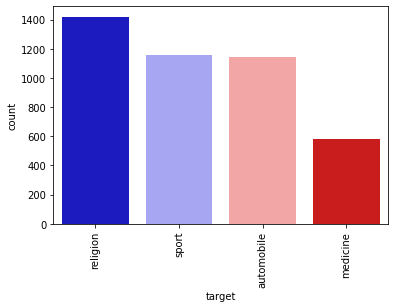

In [33]:
sns.countplot(x=training_df.target, order=[x for x, count in sorted(Counter(training_df.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

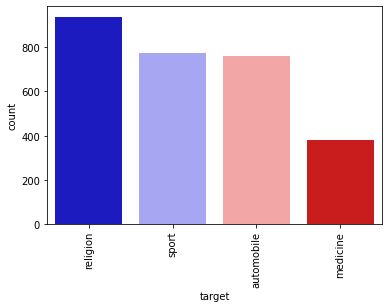

In [34]:
sns.countplot(x=test_df.target, order=[x for x, count in sorted(Counter(training_df.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

In [35]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

First tokenization of text and visualization of words highest value count is quite poor.

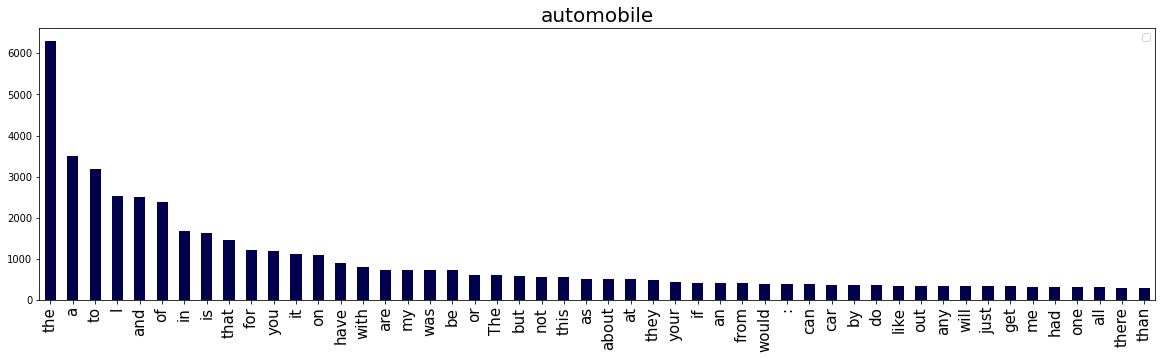

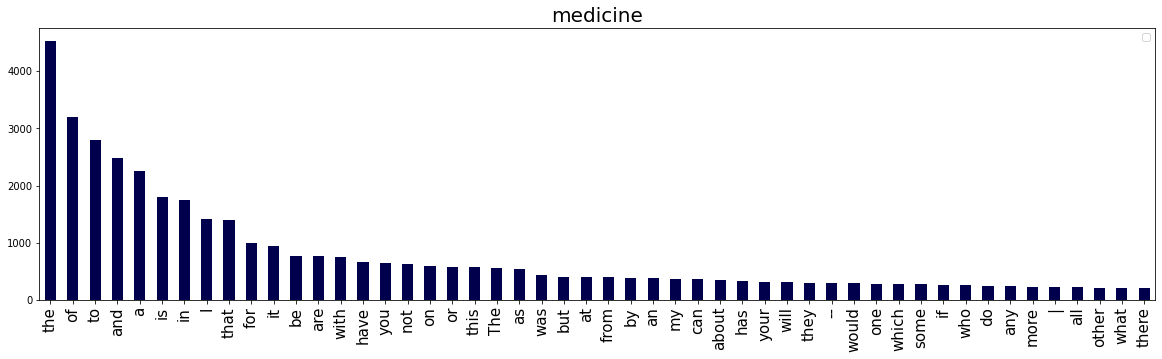

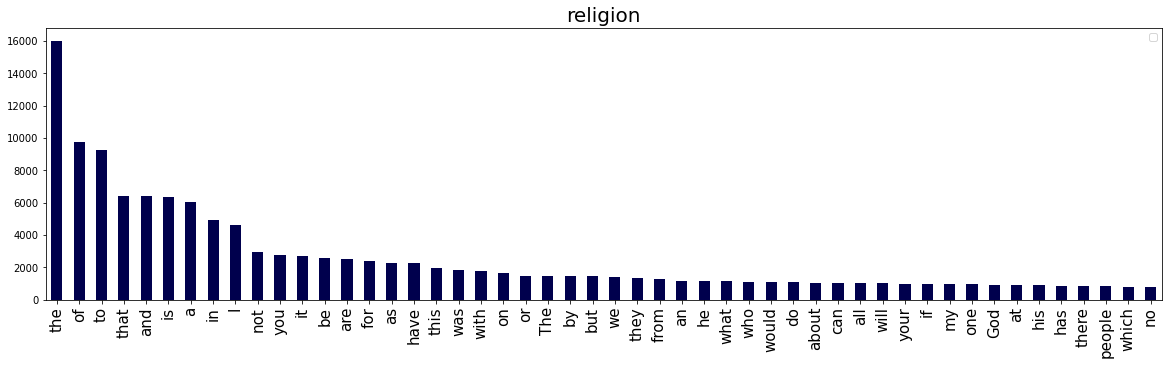

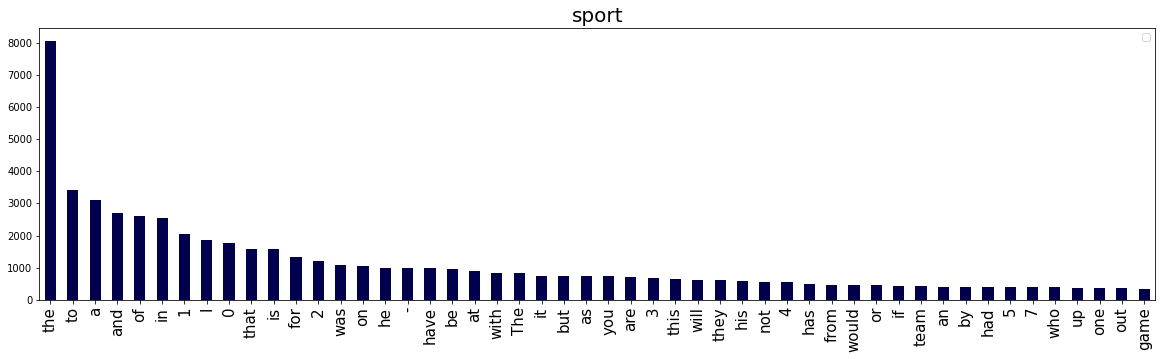

In [36]:
plot_most_common_features(training_df.text, training_df.target)

In [37]:
dataset = pd.concat([training_df,test_df], sort=True)

In [38]:
dataset

,target,text,words_count
0,automobile,I was wondering if anyone out there could enli...,91
6,medicine,There were a few people who responded to my re...,63
10,automobile,I have a line on a Ducati 900GTS 1978 model wi...,108
11,religion,"\nYep, that's pretty much it. I'm not a Jew bu...",472
15,religion,\nDon't be so sure. Look what happened to Jap...,94
...,...,...,...
7520,medicine,"First off, if I'm not mistaken, only hibernati...",95
7522,medicine,": \n: >move a little, the pain will be excruti...",171
7526,automobile,1954 MG-TF with frame-up restoration in early ...,215
7529,sport,"I sent a version of this post out a while ago,...",125


Removal of certain characters, stopwords and stemming.

In [39]:
from nltk.stem import *
from nltk.corpus import stopwords

import re

def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    letters_only = letters_only.lower()
    letters_only = re.sub('\[.*?\]', '', letters_only)
    letters_only= re.sub('http?://\S+|www\.\S+', '', letters_only)
    letters_only = re.sub('<.*?>+', '', letters_only)
    letters_only = re.sub('[%s]' % re.escape(string.punctuation), '', letters_only)
    letters_only = re.sub('\n', '', letters_only)
    letters_only = re.sub('\w*\d\w*', '', letters_only)
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))  

In [40]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset.head()

,target,text,words_count,clean_text
0,automobile,I was wondering if anyone out there could enli...,91,wonder anyon could enlighten car saw day door ...
6,medicine,There were a few people who responded to my re...,63,peopl respond request info treatment astrocyto...
10,automobile,I have a line on a Ducati 900GTS 1978 model wi...,108,line ducati gt model k clock run well paint br...
11,religion,"\nYep, that's pretty much it. I'm not a Jew bu...",472,yep pretti much jew understand jewish way thin...
15,religion,\nDon't be so sure. Look what happened to Jap...,94,sure look happen japanes citizen us world war ...


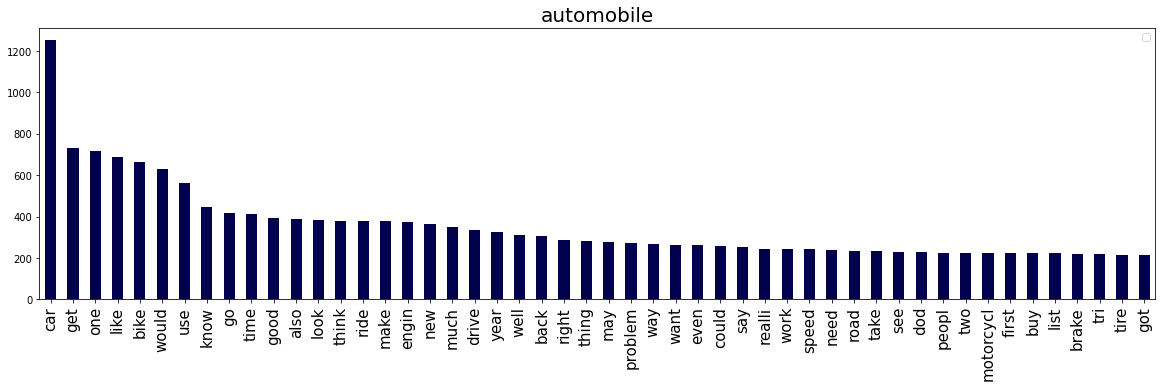

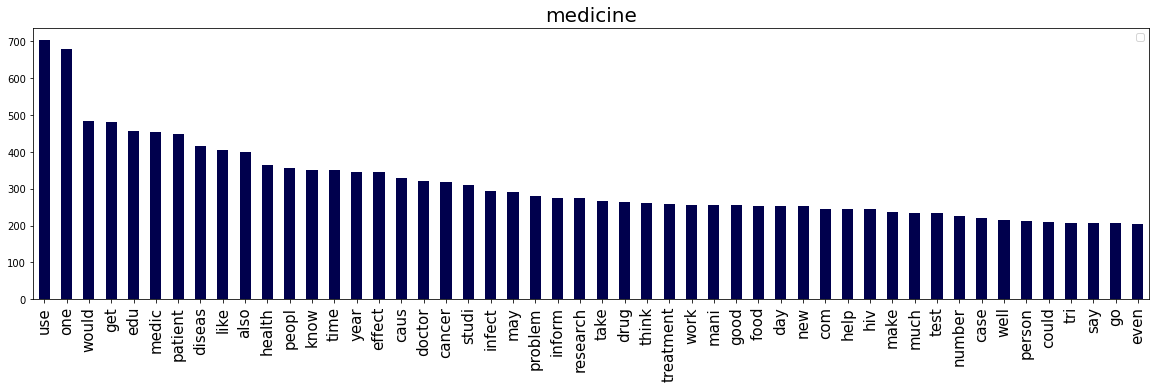

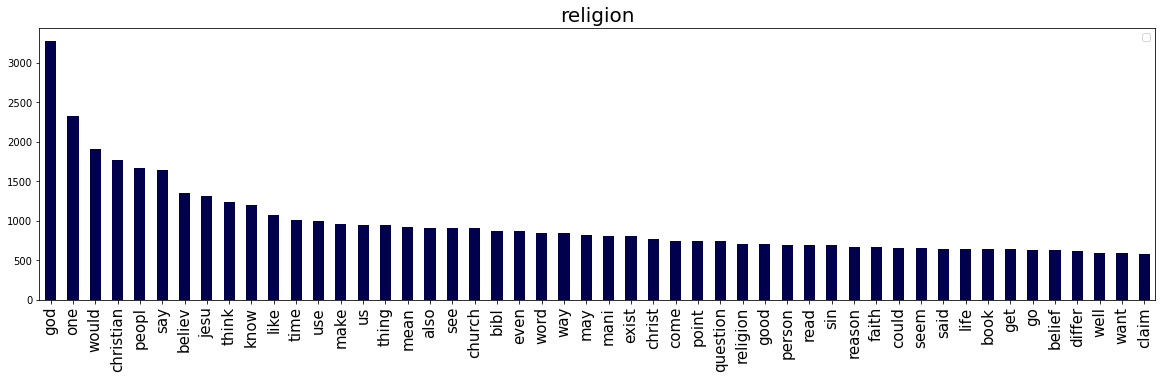

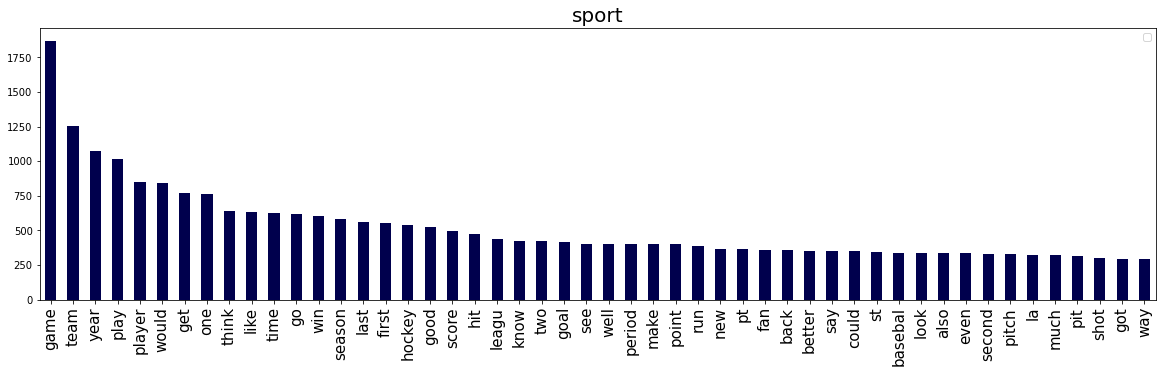

In [41]:
plot_most_common_features(dataset.clean_text, dataset.target)

In the next function clean special characters, typos, slang, abbreviations, punctuations and special characters are removed.

In [42]:
def clean(email):            
    # Special characters
    email = re.sub(r"\x89Û_", "", email)
    email = re.sub(r"\x89ÛÒ", "", email)
    email = re.sub(r"\x89ÛÓ", "", email)
    email = re.sub(r"\x89ÛÏWhen", "When", email)
    email = re.sub(r"\x89ÛÏ", "", email)
    email = re.sub(r"China\x89Ûªs", "China's", email)
    email = re.sub(r"let\x89Ûªs", "let's", email)
    email = re.sub(r"\x89Û÷", "", email)
    email = re.sub(r"\x89Ûª", "", email)
    email = re.sub(r"\x89Û\x9d", "", email)
    email = re.sub(r"å_", "", email)
    email = re.sub(r"\x89Û¢", "", email)
    email = re.sub(r"\x89Û¢åÊ", "", email)
    email = re.sub(r"fromåÊwounds", "from wounds", email)
    email = re.sub(r"åÊ", "", email)
    email = re.sub(r"åÈ", "", email)
    email = re.sub(r"JapÌ_n", "Japan", email)    
    email = re.sub(r"Ì©", "e", email)
    email = re.sub(r"å¨", "", email)
    email = re.sub(r"SuruÌ¤", "Suruc", email)
    email = re.sub(r"åÇ", "", email)
    email = re.sub(r"å£3million", "3 million", email)
    email = re.sub(r"åÀ", "", email)
            
    # Character entity references
    email = re.sub(r"&gt;", ">", email)
    email = re.sub(r"&lt;", "<", email)
    email = re.sub(r"&amp;", "&", email)
    
    # Typos, slang and informal abbreviations
    email = re.sub(r"w/e", "whatever", email)
    email = re.sub(r"w/", "with", email)
    email = re.sub(r"USAgov", "USA government", email)
    email = re.sub(r"recentlu", "recently", email)
    email = re.sub(r"Ph0tos", "Photos", email)
    email = re.sub(r"amirite", "am I right", email)
    email = re.sub(r"exp0sed", "exposed", email)
    email = re.sub(r"<3", "love", email)
    email = re.sub(r"amageddon", "armageddon", email)
    email = re.sub(r"Trfc", "Traffic", email)
    email = re.sub(r"8/5/2015", "2015-08-05", email)
    email = re.sub(r"WindStorm", "Wind Storm", email)
    email = re.sub(r"8/6/2015", "2015-08-06", email)
    email = re.sub(r"10:38PM", "10:38 PM", email)
    email = re.sub(r"10:30pm", "10:30 PM", email)
    email = re.sub(r"16yr", "16 year", email)
    email = re.sub(r"lmao", "laughing my ass off", email)   
    email = re.sub(r"TRAUMATISED", "traumatized", email)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        email = email.replace(p, f' {p} ')
        
    return email

In next function removes stopwords and performs stemming.

In [43]:
def process_text_additional(raw_text):
 
    raw_text = clean(raw_text)

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    letters_only = letters_only.lower()
    letters_only = re.sub('\[.*?\]', '', letters_only)
    letters_only= re.sub('http?://\S+|www\.\S+', '', letters_only)
    letters_only = re.sub('<.*?>+', '', letters_only)
    letters_only = re.sub('[%s]' % re.escape(string.punctuation), '', letters_only)
    letters_only = re.sub('\n', '', letters_only)
    letters_only = re.sub('\w*\d\w*', '', letters_only)
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english"))  
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))

Additional processing of the data.

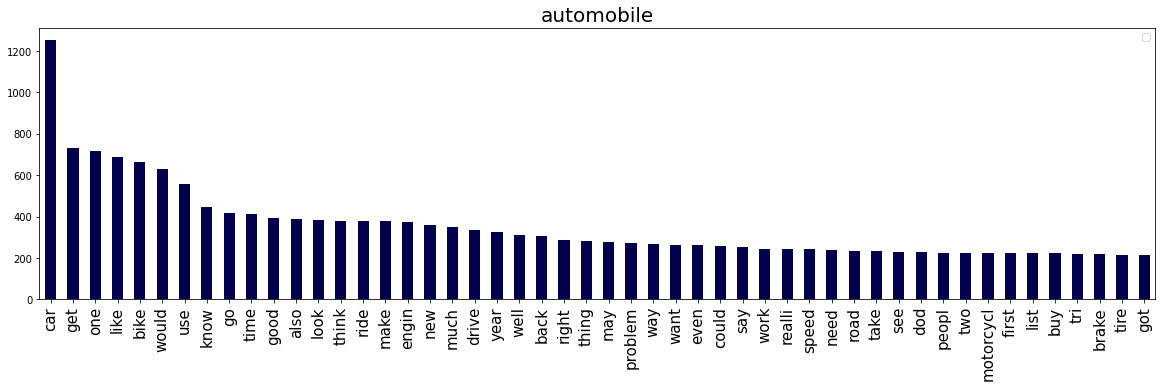

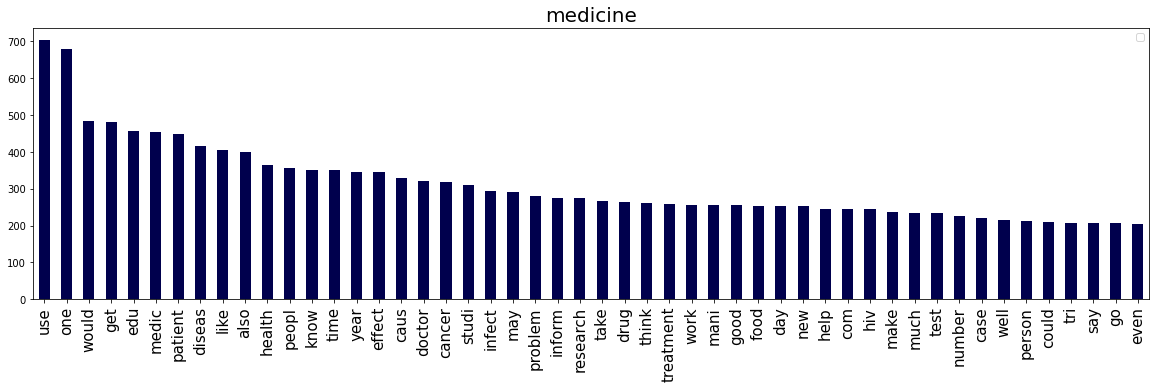

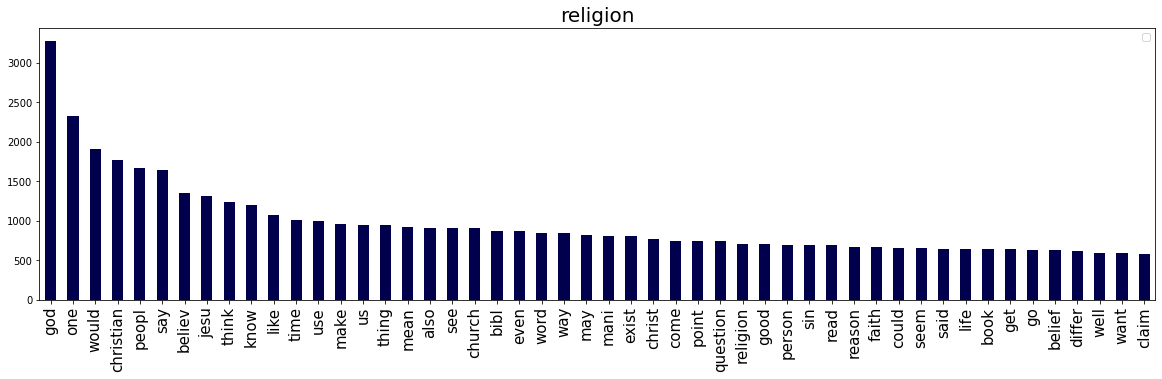

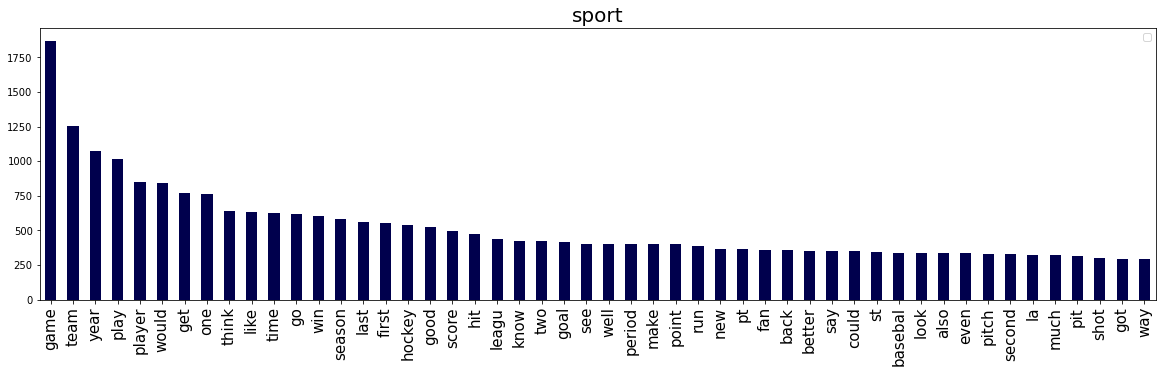

In [44]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text_additional(x))
plot_most_common_features(dataset.clean_text, dataset.target)

Encoding of the labels.

In [ ]:
# Hot encoding for the labels for train and test sets together
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset.target.values)
target_labels = le.classes_
dataset.target = le.transform(dataset.target.values)

Split of train and test sets to avoid any data leakage.

In [ ]:
X_train = dataset[0:len(training_df)][["clean_text"]]
y_train = dataset[0:len(training_df)][["target"]]

In [ ]:
X_test = dataset[len(training_df):len(dataset)][["clean_text"]]
y_test = dataset[len(training_df):len(dataset)][["target"]]

# Machine Learning Models

Correct management of train and test sets for tfidf application.

---



In [ ]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)

In [ ]:
testData = count_vect.transform(X_test['clean_text'])
test_text_tfidf_features = tfidf.transform(testData)

Grid search function to retrieve the best hyperparameters.

In [ ]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)
    
    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
        best_parameters = grid_search.best_estimator_.get_params()
        print("Best parameters set:",best_parameters)
    return grid_search, best_parameters

# Decision Trees 

In [ ]:
# Decision Trees model
from sklearn.tree import DecisionTreeClassifier

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = range(5, 200)
max_features = ['auto', 'sqrt', 'log2']

params_DT = {
    'criterion' : criterion,
    'splitter' : splitter,
    'max_depth' : max_depth,
    'max_features' : max_features
}

DT_gridsearch, DT_best_params = train_and_evaluate_classifier(train_text_tfidf_features, y_train, DecisionTreeClassifier(), params_DT)

Training model
Best score: 0.675
Best parameters set: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 164, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


In [ ]:
DT=DecisionTreeClassifier(**DT_best_params)
DT_classifier= DT.fit(train_text_tfidf_features, y_train)

In [ ]:
# predict y values over the test set
y_predict = DT_classifier.predict(test_text_tfidf_features)

In [ ]:
# calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       761
           1       0.50      0.36      0.42       382
           2       0.68      0.67      0.68       940
           3       0.57      0.74      0.64       773

    accuracy                           0.63      2856
   macro avg       0.62      0.60      0.60      2856
weighted avg       0.64      0.63      0.63      2856



In [ ]:
import joblib
joblib.dump(DT_classifier, 'DT_classifier.pkl')

['DT_classifier.pkl']

# SVM

In [ ]:
# SVM model
from sklearn.svm import SVC

svm_grid = [
  {'C': [0.01, 0.1, 1], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
 ]
# Required y_train to be specified as y_train.values.ravel() for it to run.
SVM_gridsearch, SVM_best_params = train_and_evaluate_classifier(train_text_tfidf_features, y_train.values.ravel(), SVC(), svm_grid)

Training model
Best score: 0.902
Best parameters set: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
SVM= SVC(**SVM_best_params)


In [ ]:
SVM_classifier= SVM.fit(train_text_tfidf_features, y_train.values.ravel())

In [ ]:
# predict y values over the test set
y_predict = SVM_classifier.predict(test_text_tfidf_features)

In [ ]:
# calculate metrics
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       761
           1       0.96      0.68      0.80       382
           2       0.86      0.93      0.90       940
           3       0.94      0.91      0.93       773

    accuracy                           0.89      2856
   macro avg       0.90      0.86      0.87      2856
weighted avg       0.89      0.89      0.89      2856



In [ ]:
joblib.dump(SVM_classifier, 'SVM_classifier.pkl')

['SVM_classifier.pkl']

# KNN

In [ ]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(5, 6)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = range(30, 100)
p = range(1, 4)

params_knn = {
    'n_neighbors' : n_neighbors,
    'weights' : weights,
    'algorithm' : algorithm,
    'leaf_size' : leaf_size,
    'p'  : p
}

KNN_gridsearch, KNN_best_params = train_and_evaluate_classifier(train_text_tfidf_features, y_train.values.ravel(), KNeighborsClassifier(), params_knn)

Training model
Best score: 0.398
Best parameters set: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [ ]:
KNN = KNeighborsClassifier(**KNN_best_params)
KNN_classifier= KNN.fit(train_text_tfidf_features, y_train.values.ravel())

In [ ]:
# predict y values over the test set
y_predict = KNN_classifier.predict(test_text_tfidf_features)

In [ ]:
# calculate metrics
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       761
           1       1.00      0.01      0.01       382
           2       1.00      0.01      0.02       940
           3       0.27      1.00      0.43       773

    accuracy                           0.28      2856
   macro avg       0.82      0.26      0.12      2856
weighted avg       0.80      0.28      0.13      2856



In [ ]:
joblib.dump(KNN_classifier, 'KNN_classifier.pkl')

['KNN_classifier.pkl']

# MaxEnt Classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100]}
MaxEnt_gridsearch, MaxEnt_best_params = train_and_evaluate_classifier(train_text_tfidf_features, y_train.values.ravel(), LogisticRegression(), max_ent_grid)

Training model
Best score: 0.910
Best parameters set: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
MaxEnt = LogisticRegression(**MaxEnt_best_params)
MaxEnt_classifier= MaxEnt.fit(train_text_tfidf_features, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# predict y values over the test set
y_predict = MaxEnt_classifier.predict(test_text_tfidf_features)

In [ ]:
# calculate metrics
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       761
           1       0.94      0.76      0.84       382
           2       0.88      0.92      0.90       940
           3       0.93      0.92      0.92       773

    accuracy                           0.90      2856
   macro avg       0.91      0.88      0.89      2856
weighted avg       0.90      0.90      0.90      2856



In [ ]:
joblib.dump(MaxEnt_classifier, 'MaxEnt_classifier.pkl')

['MaxEnt_classifier.pkl']

# Naive Bayes

In [ ]:
NB_params={'alpha':[0,1]}
NB_gridsearch, NB_best_params  = train_and_evaluate_classifier(train_text_tfidf_features, y_train.values.ravel(), MultinomialNB(), NB_params)

Training model
Best score: 0.909
Best parameters set: {'alpha': 0, 'class_prior': None, 'fit_prior': True}


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [ ]:
NB=MultinomialNB()
NB_classifier= NB.fit(train_text_tfidf_features, y_train.values.ravel())

In [ ]:
# predict y values over the test set
y_predict = NB_classifier.predict(test_text_tfidf_features)

In [ ]:
# calculate metrics
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       761
           1       1.00      0.21      0.35       382
           2       0.69      0.98      0.81       940
           3       0.96      0.89      0.93       773

    accuracy                           0.82      2856
   macro avg       0.89      0.74      0.74      2856
weighted avg       0.86      0.82      0.80      2856



In [ ]:
joblib.dump(NB_classifier, 'NB_classifier.pkl')

['NB_classifier.pkl']

# LSTM

In [43]:
import fastai
fastai.__version__

'2.3.1'

In [44]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *
from fastai.text import *

In [45]:
training_df.drop(['words_count'],axis=1,inplace=True)
test_df.drop(['words_count'],axis=1,inplace=True)

In [46]:
df_all = pd.concat([training_df, test_df])
df_all

,text,target
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",automobile
6,"There were a few people who responded to my request for info on\ntreatment for astrocytomas through email, whom I couldn't thank\ndirectly because of mail-bouncing probs (Sean, Debra, and Sharon). So\nI thought I'd publicly thank everyone.\n\nThanks! \n\n(I'm sure glad I accidentally hit ""rn"" instead of ""rm"" when I was\ntrying to delete a file last September. ""Hmmm... 'News?' What's\nthis?""....)",medicine
10,"I have a line on a Ducati 900GTS 1978 model with 17k on the clock. Runs\nvery well, paint is the bronze/brown/orange faded out, leaks a bit of oil\nand pops out of 1st with hard accel. The shop will fix trans and oil \nleak. They sold the bike to the 1 and only owner. They want $3495, and\nI am thinking more like $3K. Any opinions out there? Please email me.\nThanks. It would be a nice stable mate to the Beemer. Then I'll get\na jap bike and call myself Axis Motors!\n\n-- \n-----------------------------------------------------------------------\n""Tuba"" (Irwin) ""I honk therefor...",automobile
11,"\nYep, that's pretty much it. I'm not a Jew but I understand that this is the\nJewish way of thinking. However, the Jews believe that the Covenant between\nYHWH and the Patriarchs (Abraham and Moses, in this case) establishes a Moral\nCode to follow for mankind. Even the Jews could not decide where the boundaries\nfall, though.\n\nAs I understand it, the Sadducees believed that the Torah was all that was\nrequired, whereas the Pharisees (the ancestors of modern Judaism) believed that\nthe Torah was available for interpretation to lead to an understanding of\nthe required Morality in all it...",religion
15,"\nDon't be so sure. Look what happened to Japanese citizens in the US during\nWorld War II. If you're prepared to say ""Let's round these people up and\nstick them in a concentration camp without trial"", it's only a short step to\ngassing them without trial. After all, it seems that the Nazis originally\nonly intended to imprison the Jews; the Final Solution was dreamt up partly\nbecause they couldn't afford to run the camps because of the devastation\ncaused by Goering's Total War. Those who weren't gassed generally died of\nmalnutrition or disease.\n",religion
...,...,...
7520,"First off, if I'm not mistaken, only hibernating animals have brown fat,\nnot humans.\n\nSecondly, your description sounds just like 2,4-dinitrophenol. This is an\nuncoupler of respiratory chain oxidative phosphorylation. Put in layman's\nterms, it short-circuits the mitochondria, causing food energy to be\nturned into heat.\n\n2,4-DNP was popular in the 1930's for weight reduction. In controlled\namounts, it raises body temperature as the body compensates for the\nreduced amount of useful energy available. It is very dangerous.\nIt would be wiser to adjust to your present body form, r...",medicine
7522,": \n: >move a little, the pain will be excrutiating. I was told by my doctor\n: >at that time that the pain was comparable to that of childbirth. (Yes,\n: >by a male doctor, so I'm sure some of you women will disagree). I'd\n: >really like to know the truth in this, so maybe some of you women who\n: >have had a baby and a kidney stone could fill me in. \n: \n: One more reason for men to learn the Lamaze breathing techniques, in order\n: to be able to get some pain reduction instantly, wherever you are.\n: -- \n: :- Michael A. Covington, Associate Research Scientist : *****\n: :-...",medicine
7526,"1954 MG-TF with frame-up restoration in ear

In [47]:
# Language model data
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)
).dataloaders(df_all, bs=64, seq_len=40)

dls_lm.show_batch(max_n=5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj says who ? xxmaj other than a hear - say god . \n\n\n xxmaj you sure do n't understand it . \n\n\n xxmaj bill , i hereby award you the xxmaj golden xxmaj shovel xxmaj award for the","xxmaj says who ? xxmaj other than a hear - say god . \n\n\n xxmaj you sure do n't understand it . \n\n\n xxmaj bill , i hereby award you the xxmaj golden xxmaj shovel xxmaj award for the xxunk"
1,get his points . xxmaj anyone in xxmaj vancouver care to comment on xxmaj courtnall \n as a defensive liability ? \n\n xxmaj ken xxmaj xxunk for xxmaj dave xxmaj poulin ( flyers ) + + . xxmaj any more,his points . xxmaj anyone in xxmaj vancouver care to comment on xxmaj courtnall \n as a defensive liability ? \n\n xxmaj ken xxmaj xxunk for xxmaj dave xxmaj poulin ( flyers ) + + . xxmaj any more questions
2,times the xxup rda . xxmaj is \n this safe ? ! ? . \n\n xxmaj also what was the condition that xxup b6 was theraputic for ? \n\n xxmaj mail would be just fine if you do n't want,the xxup rda . xxmaj is \n this safe ? ! ? . \n\n xxmaj also what was the condition that xxup b6 was theraputic for ? \n\n xxmaj mail would be just fine if you do n't want to
3,- 03 01 - 05 \n\n xxup national xxup east \n xxmaj philadelphia xxmaj phillies 08 02 xxunk -- 8 - 2 xxmaj lost 1 05 - 01 03 - 01 \n xxmaj pittsburgh xxmaj pirates 07 03 .700 1.0,03 01 - 05 \n\n xxup national xxup east \n xxmaj philadelphia xxmaj phillies 08 02 xxunk -- 8 - 2 xxmaj lost 1 05 - 01 03 - 01 \n xxmaj pittsburgh xxmaj pirates 07 03 .700 1.0 7
4,xxunk xxmaj xxunk xxrep 3 - xxunk \n xxmaj yemen - xxmaj yemen xxrep 3 - 17.12.92 \n\n xxup total xxunk \n\n\n\n xxup europe \n\n xxmaj xxunk - xxmaj xxunk xxrep 3 - 30.09.92 \n xxmaj austria - xxmaj xxunk,xxmaj xxunk xxrep 3 - xxunk \n xxmaj yemen - xxmaj yemen xxrep 3 - 17.12.92 \n\n xxup total xxunk \n\n\n\n xxup europe \n\n xxmaj xxunk - xxmaj xxunk xxrep 3 - 30.09.92 \n xxmaj austria - xxmaj xxunk xxunk


In [48]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.01659586876630783, lr_steep=0.05495408922433853)

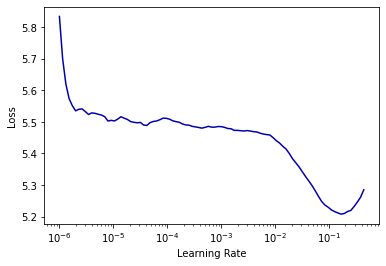

In [49]:
learn.lr_find(start_lr=1e-6, end_lr=1)

Trained the last layers in our model to avoid forgetting everything. 

In [51]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.800987,4.068958,0.272031,58.495995,01:35
1,3.810193,4.043777,0.275203,57.041382,01:36
2,3.642295,3.997131,0.281456,54.441727,01:35
3,3.384662,3.960312,0.287065,52.473679,01:34
4,3.218423,3.955999,0.288654,52.247860,01:35


Now that our model is in a stable state, we can further train our model by unfreeze all the layers.

In [52]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.113851,3.957171,0.296547,52.309143,01:44
1,3.016634,3.941424,0.303891,51.491856,01:44
2,2.935951,3.935807,0.310906,51.203430,01:44
3,2.686037,3.962655,0.314766,52.596790,01:44
4,2.590878,4.038105,0.316016,56.718731,01:44
5,2.367571,4.099312,0.313958,60.298805,01:44
6,2.153671,4.192963,0.314802,66.218681,01:45
7,1.940677,4.256079,0.314995,70.532898,01:44
8,1.820765,4.307884,0.313299,74.283157,01:44
9,1.839024,4.323715,0.312807,75.468491,01:43


In [53]:
TEXT = "My country is Spain"
N_WORDS = 20
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [54]:
print("\n".join(preds))

My country is Spain , so our country has two : Latin , one Italian , Latin , and one 

My country is Spain , but i am a Catholic . i have a fourteen year old 
 Catholic who was a


In [55]:
learn.save_encoder('ft_enc_extended')

In [56]:
dls_class = DataBlock(
    blocks=(
        TextBlock.from_df('text', # We take the textual information from the column "text" in the dataset
                          seq_len=40, # Maximum length
                          vocab=dls_lm.vocab # We use the same vocabulary representation than the one used for the LM
                          ), 
            CategoryBlock), # Because we will use these data for classification
    get_x=ColReader('text'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(0.2) # Randomly splits the dataset (20% for Validation, 80% for training)
).dataloaders(training_df, bs=64)

dls_class.show_batch(max_n=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj archive - name : hockey - faq \n\n rec.sport.hockey answers to xxmaj frequently xxmaj asked xxmaj questions and other news : \n▁\n xxmaj contents : \n\n 0 . xxmaj new xxmaj info . \n 1 . xxup nhl \n 2 . xxup nhl xxmaj minor xxmaj leagues \n 3 . xxmaj college xxmaj hockey ( north xxmaj america ) \n 4 . xxmaj other leagues ( e.g. xxmaj europe , xxmaj canada xxmaj cup tournament ) \n 5 . xxmaj e - mail files \n 6 . xxup usenet xxmaj hockey xxmaj pool \n 7 . xxmaj up - coming xxmaj dates \n 8 . xxmaj answers to some frequently asked questions \n 9 . xxmaj miscellaneous \n▁\n▁ xxmaj send comments , suggestions and criticisms regarding this xxup faq list via xxunk \n mail to hamlet@u.washington.edu . \n▁\n▁ xxrep 74 - \n▁\n▁ 0 . xxmaj new xxmaj info",sport
1,"xxbos xxmaj the recent rise of nostalgia in this group , combined with the \n▁ incredible level of utter bullshit , has prompted me to xxunk \n▁ through my archives and pull out some of "" the xxmaj best of alt.atheism "" \n▁ for your reading pleasure . xxmaj i 'll post a couple of these a day \n▁ unless group xxunk demands that i stop , or i run out of good \n▁ material . \n\n▁ i have n't been particularly careful in the past about saving \n▁ attributions . i think the following comes from xxmaj john xxup a. xxmaj johnson , \n▁ but someone correct me if xxmaj i 'm wrong . xxmaj this is probably the longest \n▁ of my entire collection . \n\n▁ xxrep 56 _ \n\n\n▁ xxmaj so that the \n▁ xxmaj prophecy be \n▁ xxmaj fulfilled \n\n▁ * * * \n\n▁ xxmaj in",religion
2,"xxbos xxrep 13 - cut here xxrep 17 - \n xxmaj volume 6 , xxmaj number 10 xxmaj april 20 , 1993 \n\n▁ + xxrep 48 - + \n▁ ! ! \n▁ ! xxmaj health info - com xxmaj network ! \n▁ ! xxmaj medical xxmaj newsletter ! \n▁ + xxrep 48 - + \n▁ xxmaj editor : xxmaj david xxmaj dodell , xxup d.m.d . \n▁ xxunk xxmaj north xxunk xxmaj street , xxmaj suite 210 , xxmaj scottsdale , xxmaj arizona xxunk - xxunk xxup usa \n▁ xxmaj telephone +1 ( 602 ) 860 - 1121 \n▁ xxup fax +1 ( 602 ) 451 - xxunk \n\n xxmaj compilation xxmaj copyright 1993 by xxmaj david xxmaj dodell , xxup d.m.d . xxmaj all rights xxmaj reserved . \n xxmaj license is hereby granted to xxunk on electronic media for which no \n fees are charged , so long",medicine
3,"xxbos xxmaj archive - name : atheism / introduction \n xxmaj alt - atheism - archive - name : introduction \n xxmaj last - modified : 5 xxmaj april 1993 \n xxmaj version : 1.2 \n\n▁ xxrep 5 - xxup begin xxup pgp xxup signed xxup message xxrep 5 - \n\n▁ xxmaj an xxmaj introduction to xxmaj atheism \n▁ by mathew < mathew@mantis.co.uk > \n\n xxmaj this article attempts to provide a general introduction to atheism . xxmaj whilst i \n have tried to be as neutral as possible regarding contentious issues , you \n should always remember that this document represents only one viewpoint . i \n would encourage you to read widely and draw your own conclusions ; some \n relevant books are listed in a companion article . \n\n xxmaj to provide a sense of xxunk and progression , i have presented this article \n as an",religion
4,"xxbos xxmaj archive - name : atheism / faq \n xxmaj alt - atheism - archive - name : faq \n xxmaj last - modified : 5 xxmaj april 1993 \n xxmaj version : 1.1 \n\n▁ alt.atheism frequently - asked xxmaj questions \n\n xxmaj this file contains responses to articles which occur repeatedly in \n alt.atheism . xxmaj points covered here are ones which are not covered in the \n "" introduction to xxmaj atheism "" ; you are advised to read that article as well \n before posting . \n\n xxmaj these answers are not intended to be exhaustive or definitive . xxmaj the purpose of \n the periodic xxup faq postings is not to xxunk debate , but to raise its level . xxmaj if \n you have something to say concerning one of these questions and which is n't \n covered by the answer given , please",religion
5,"xxbos xxrep 13 - cut here xxrep 17 - \n limits of azt 's efficacy and now suggest using t

Create the classifier taking our fine-tuned encoder.

In [68]:
#needed to include average='weighted' for being a multiclass classifier.
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.8, metrics=[accuracy,FBeta(beta=1,average='weighted')]).to_fp16()
learn.load_encoder('ft_enc_extended')
learn.freeze()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.007585775572806597)

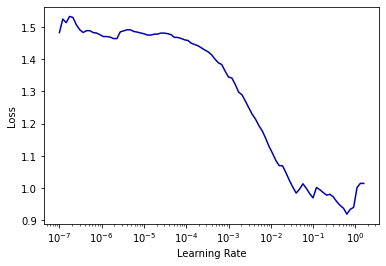

In [69]:
learn.lr_find()

In [70]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.611168,0.301256,0.909302,0.909372,00:14


In [71]:
learn.save('lstm_1')

Path('models/lstm_1.pth')

Now it is time to gradually unfreeze the rest of the model and train it together in different steps.

In [72]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.465131,0.271109,0.902326,0.902815,00:14


In [74]:
learn.save('lstm_2')

Path('models/lstm_2.pth')

In [75]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/2/(2.6**4),1e-2/2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.384734,0.251077,0.916279,0.916335,00:17


In [76]:
learn.save('lstm_3')

Path('models/lstm_3.pth')

In [77]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-2/10/(2.6**4),1e-2/10))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.335264,0.245157,0.916279,0.916371,00:19
1,0.349393,0.236634,0.923256,0.923378,00:20
2,0.343388,0.239180,0.920930,0.921232,00:19
3,0.318837,0.231933,0.927907,0.928195,00:20
4,0.305226,0.222014,0.923256,0.923435,00:20
5,0.293036,0.215446,0.925581,0.925647,00:20
6,0.268773,0.213182,0.930233,0.930283,00:19
7,0.268122,0.217845,0.926744,0.926896,00:19
8,0.258949,0.211775,0.934884,0.934955,00:19
9,0.252698,0.212587,0.931395,0.931417,00:20


In [78]:
learn.save('lstm_4')

Path('models/lstm_4.pth')

In [79]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3
row_0,,,,
0,216,3,8,11
1,1,96,4,0
2,6,5,270,8
3,6,1,4,221


In [80]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       229
           1       0.95      0.91      0.93       105
           2       0.93      0.94      0.94       286
           3       0.95      0.92      0.94       240

    accuracy                           0.93       860
   macro avg       0.94      0.93      0.93       860
weighted avg       0.93      0.93      0.93       860



The model is better not only in terms of accuracy, but also in its performance for all the classes when compared to the non Deep Learning models

As expected, there are some classes for which the model performs better (they are easier to predict or we have more data for them). However, we get a reasonable performance for most of the classes

In [81]:
learn.save('final_lstm_model')

Path('models/final_lstm_model.pth')

Finally try a classification with our LSTM model:

In [ ]:
learn.predict("homebrew not working")

# Transformers

In [ ]:
# Try a distill transformer and other models.

In [45]:
import tensorflow as tf
import ktrain
from ktrain import text

In [46]:
trn, val, preproc = text.texts_from_df(training_df,'text',preprocess_mode='bert',label_columns='target',verbose=True, maxlen=32) # Process the input based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=128) # Creates the learning process to fine-tune bert and train the classifier.

['automobile', 'medicine', 'religion', 'sport']
      automobile  medicine  religion  sport
1415         0.0       0.0       0.0    1.0
2599         0.0       1.0       0.0    0.0
2265         0.0       1.0       0.0    0.0
3624         0.0       0.0       0.0    1.0
8717         0.0       0.0       0.0    1.0
['automobile', 'medicine', 'religion', 'sport']
       automobile  medicine  religion  sport
11013         0.0       0.0       1.0    0.0
7800          0.0       0.0       0.0    1.0
684           0.0       0.0       1.0    0.0
6201          0.0       0.0       1.0    0.0
1700          0.0       1.0       0.0    0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 32
done.


simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
31/31 [==============================] - 1076s 34s/step - loss: 1.3623 - accuracy: 0.3585
Epoch 2/2
31/31 [==============================] - 970s 31s/step - loss: 40.1225 - accuracy: 0.3100


done.
Visually inspect loss plot and select learning rate associated with falling loss


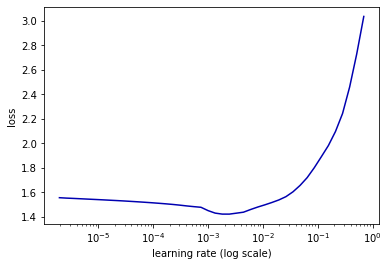

In [47]:
learner.lr_find(show_plot=True, max_epochs=2)

In [48]:
learner.autofit(lr=1e-4, # Learning Rate 
                epochs=5, # Number of epochs to train the model
                early_stopping=2, # If the model does not improve after 2 epochs, we stop the training
                reduce_on_plateau=1,  # If the model does not improve aftear 1 epoch, we reduce the learning rate
                monitor='val_loss', # Metric to monitor the peformance of the model (loss computed on the validation dataset)
                checkpoint_folder='transformer_cpt_1' # After each epoch we store a checkpoint of the model
                )



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/5
31/31 [==============================] - 1081s 34s/step - loss: 0.8550 - accuracy: 0.6485 - val_loss: 0.4238 - val_accuracy: 0.8515
Epoch 2/5
31/31 [==============================] - 1043s 34s/step - loss: 0.3292 - accuracy: 0.8789 - val_loss: 0.3805 - val_accuracy: 0.8608
Epoch 3/5
31/31 [==============================] - 1042s 34s/step - loss: 0.1883 - accuracy: 0.9367 - val_loss: 0.4225 - val_accuracy: 0.8608

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 4/5
31/31 [==============================] - 1073s 35s/step - loss: 0.0763 - accuracy: 0.9775 - val_loss: 0.4793 - val_accuracy: 0.8724

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Weights from best epoch have been loaded into model.


In [49]:
learner.save_model('transformer_1') # Saving the trained model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Reduced the learning rate by a magnitude order and try to retrain for one more epoch an check the performance

In [50]:
learner.unfreeze()
learner.fit_onecycle(1e-4/10, 1, checkpoint_folder='transformer_cpt_2')



begin training using onecycle policy with max lr of 1e-05...
31/31 [==============================] - 1100s 35s/step - loss: 0.1913 - accuracy: 0.9370 - val_loss: 0.3906 - val_accuracy: 0.8654


In [51]:
learner.save_model('transformer_2') # Store the final model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [52]:
learner.validate(class_names=['religion', 'automobile', 'medicine','sport'] )

              precision    recall  f1-score   support

    religion       0.85      0.85      0.85       108
  automobile       0.84      0.83      0.84        59
    medicine       0.86      0.87      0.87       154
       sport       0.89      0.89      0.89       110

    accuracy                           0.87       431
   macro avg       0.86      0.86      0.86       431
weighted avg       0.87      0.87      0.87       431



array([[ 92,   1,   8,   7],
       [  2,  49,   7,   1],
       [  9,   7, 134,   4],
       [  5,   1,   6,  98]])

In [53]:
learner.view_top_losses(n=10, preproc=preproc)

----------
id:259 | loss:7.71 | true:religion | pred:sport)

[CLS] larry l . over ##acker writes , responding to simon : i may be interesting to see some brief selections posted to the net . my understanding is that ss [SEP]
----------
id:32 | loss:6.06 | true:sport | pred:medicine)

[CLS] i made a mistake on the posted article [ been fighting food poisoning for last 24 hours . . . ] the second paragraph should state the following . . [SEP]
----------
id:407 | loss:5.69 | true:sport | pred:religion)

[CLS] count me interested in a cardinal ' s mail ##ing list . if anyone finds one or starts one , please let me know . thanks , dick det ##weiler [SEP]
----------
id:167 | loss:5.42 | true:religion | pred:automobile)

[CLS] this isn ' t true . many people are forced to use the " automobile system . " i certainly don ' t use it by choice . if there [SEP]
----------
id:267 | loss:4.84 | true:religion | pred:automobile)

[CLS] as to what that head ##piece is . . . . ( by cho ##rt @ cr ##l . n

In [54]:
#!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [57]:
predictor = ktrain.get_predictor(learner.model, preproc)

predictor.explain("There's a lot of whining about how much players are overpaid.I thought I'd put together an underpaid team that could win a pennant.  I splurged and let four of the players earn as much as half a million dollars; the highest-paid player is Frank Thomas, at $900K.  I cut some players, like Kenny Lofton, Chris Hoiles, Keith Mitchell, Tim Wakefield, and a bunch of pitchers, all of whom could have arguably made the team better at a cost of $1 million for the lot of them.  The total team salary is $7,781,500, averaging slightly over $300K a player.  If that's too steep, you can dump Thomas and Bagwell, replacing them with Paul Sorrento and a minimum wager to save a bit over a million dollars, and still have one of the best teams in the majors.")